In [112]:
%%capture
%pip install ipython pandas matplotlib

In [113]:
import pandas as pd
import numpy as np
import math as m

pd.options.display.precision = 2

In [114]:
STEP_FACTOR = 2 ** (1 / 2)
MIN_ZOOM = 0.8

Calculate the zoom for a given step:
* zoom: $z$
* step: $s$
* STEP_FACTOR: $f$

$$
  z = f ^ s \\
  \ln{z} = s \ln{f} \\
  s = \frac{\ln{z}}{\ln{f}}
$$

-0.64   0.80
0.00    1.00
1.00    1.41
2.00    2.00
3.00    2.83
4.00    4.00
5.00    5.66
6.00    8.00
dtype: float64

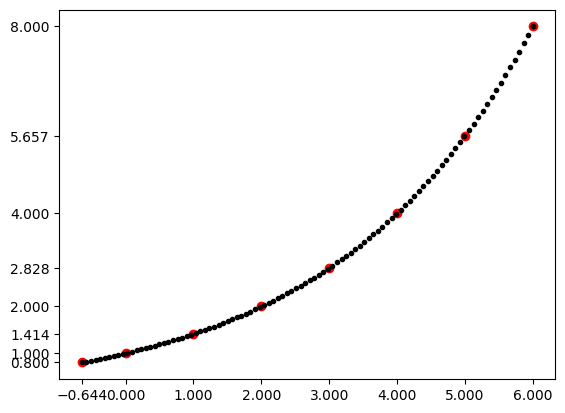

In [115]:
min_zoom_step = m.log(MIN_ZOOM) / m.log(STEP_FACTOR)

steps = pd.Series(
    STEP_FACTOR ** (index := np.array([min_zoom_step] + list(range(7)))),
    index,
)

cont = pd.Series(
    STEP_FACTOR ** (index := np.linspace(steps.index[0], steps.index[-1], 100)), index
)

ax = steps.plot(
    style="ro",
    xticks=steps.index,
    yticks=steps,
    # logy=True,
)
cont.plot(style="k.", ax=ax)
steps